In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as distributions
numpyro.set_platform("cpu")
numpyro.set_host_device_count(1)
import data.datasets as datasets
from transformations import Sequential
import visualization
import models
from inference import run
from utils.equioutput import MLPSymmetryHelper
from jax import tree_util
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves
import flax.linen as nn
from flax.core import freeze, unfreeze
import numpy as np
import datetime
import optax
import inference
from utils import settings

rng_key = jax.random.PRNGKey(0)

In [2]:
#dataset = datasets.Izmailov()
dataset = datasets.Sinusoidal()

In [3]:
model_transformation = Sequential([
    nn.Dense(16),
    nn.tanh,
    nn.Dense(1)
])

In [4]:
rng_key, rng_key_ = jax.random.split(rng_key)
parameters = {
    "transformation": model_transformation.init(rng_key_, dataset[0][0]),
    "log_std": 0.0
}

In [5]:
# train a model
optimizer = optax.adam(learning_rate=0.001)

parameters, optimizer_state = inference.point_estimate(
    transformation=model_transformation,
    loss_function=inference.ridge_loss,
    parameters=parameters,
    dataset=dataset,
    epochs=4001,
    optimizer=optimizer,
    report_at=100
)

epoch 0 loss: 177.44496154785156
epoch 100 loss: 90.03166961669922
epoch 200 loss: 73.90837860107422
epoch 300 loss: 65.97959899902344
epoch 400 loss: 57.67083740234375
epoch 500 loss: 47.86381530761719
epoch 600 loss: 35.57733917236328
epoch 700 loss: 20.404857635498047
epoch 800 loss: 3.4778575897216797
epoch 900 loss: -12.706354141235352
epoch 1000 loss: -25.243911743164062
epoch 1100 loss: -32.96477508544922
epoch 1200 loss: -37.23577117919922
epoch 1300 loss: -39.75711441040039
epoch 1400 loss: -41.40582275390625
epoch 1500 loss: -42.56694030761719
epoch 1600 loss: -43.43216323852539
epoch 1700 loss: -44.107879638671875
epoch 1800 loss: -44.655433654785156
epoch 1900 loss: -45.11118698120117
epoch 2000 loss: -45.49729919433594
epoch 2100 loss: -45.82805252075195
epoch 2200 loss: -46.112831115722656
epoch 2300 loss: -46.35855484008789
epoch 2400 loss: -46.57084655761719
epoch 2500 loss: -46.754554748535156
epoch 2600 loss: -46.914283752441406
epoch 2700 loss: -47.05438232421875
epo

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


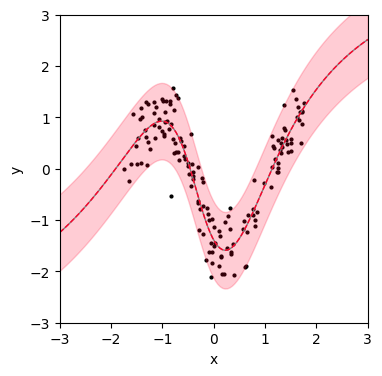

In [6]:
samples_parameters = tree_util.tree_reduce(lambda a, b: jnp.concatenate([a.flatten(), b.flatten()]), parameters["transformation"])[jnp.newaxis]

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.05,
            aleatoric=True
        )
    )
)
figure.plot(
    dataset=dataset,
    transformation=model_transformation.apply_from_vector,
    parameters_list=[samples_parameters],
    std=jnp.exp(parameters["log_std"])
)

In [7]:
# simple path function
def make_bezier(a, b):
    def bezier(t, theta):
        return jnp.power(1.0 - t, 2) * a + 2.0 * t * (1 - t) * theta + jnp.power(t, 2) * b
    return jax.jit(bezier)

In [8]:
diagonal = -np.ones(49)
diagonal[-17] = 1.0
t = jnp.diag(diagonal)

a = samples_parameters[0]
b = t @ a

bezier = make_bezier(a, b)

In [9]:
rng_key, rng_key_ = jax.random.split(rng_key)
params = {
    "theta": jax.random.normal(rng_key_, a.shape),
}

In [10]:
def make_loss_func(x_batched, y_batched):
    def ridge_loss(rng_key, params):
        std = jnp.exp(parameters["log_std"])
        theta = params["theta"]
        t = jax.random.uniform(rng_key, (1, ))
        parameters_sample = bezier(t, theta)
        
        # loss per sample
        def single_sample(x, y):
            y_pred = model_transformation.apply_from_vector(x, parameters_sample)
            loss = (0.5 / std ** 2) * jnp.inner(y - y_pred, y - y_pred) + jnp.log(std)
            return loss
        
        # regularization
        params_penalty = jnp.power(parameters_sample, 2).sum()
        
        return jnp.sum(jax.vmap(single_sample)(x_batched, y_batched)) + params_penalty
    return jax.jit(ridge_loss)

In [11]:
loss = make_loss_func(dataset.data[:, dataset.conditional_indices], dataset.data[:, dataset.dependent_indices])

In [12]:
# optimization
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)
params_history = []

In [13]:
#loss = make_loss_func(X_train, y_train)
for i in range(10001):
    rng_key, rng_key_ = jax.random.split(rng_key)
    loss_val, grads = jax.value_and_grad(loss, -1)(rng_key_, params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    params_history.append(params)
    
    if i % 1000 == 0:
        print("loss", i, loss_val, jnp.sqrt((params["theta"] ** 2).sum()))

loss 0 982.17065 5.646112
loss 1000 357.836 5.31045
loss 2000 179.97919 5.399868
loss 3000 -43.889484 5.9442134
loss 4000 98.47227 7.177778
loss 5000 7.65191 8.573796
loss 6000 -22.873678 9.56703
loss 7000 -36.096268 10.098965
loss 8000 -48.359413 10.33005
loss 9000 -8.64094 10.356614
loss 10000 -30.806892 10.465893


In [14]:
indices = np.linspace(0.0, len(params_history)-1, 8).astype(np.int32)
print(indices)
parameters_paths = []
for i in indices:
    ts = jnp.linspace(0.0, 1.0, 128)
    parameters_path = jax.vmap(bezier, (0, None))(ts, params_history[i]["theta"])    
    parameters_paths.append((i, parameters_path))

[    0  1428  2857  4285  5714  7142  8571 10000]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 315.55it/s]


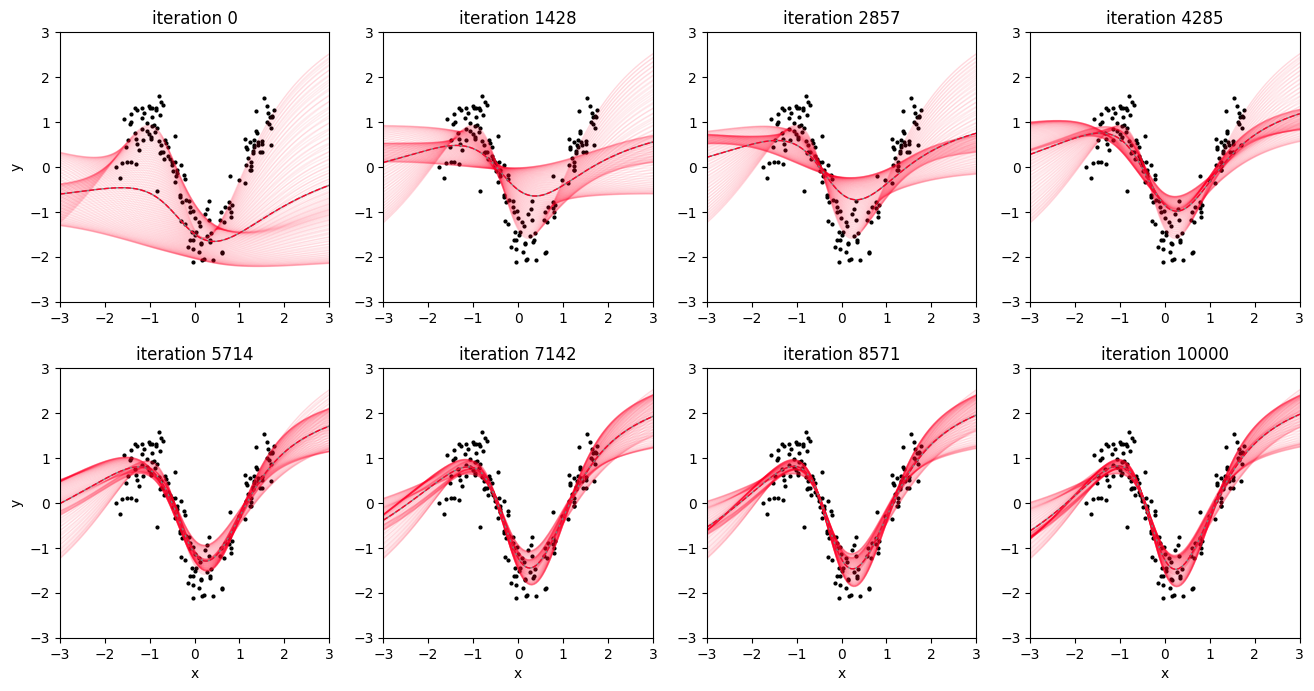

In [15]:
figure = visualization.SequenceFigure(
    settings=settings.SettingsSequenceFigure(
        settings_plot=settings.SettingsPlot(alpha=0.08)
    )
)
figure.plot(dataset=dataset, transformation=model_transformation.apply_from_vector, parameters_paths=parameters_paths)